Group Members: Alyson Brown, Apoorva Reddy, Avani Sharma, Jeffery Fulkerson, Abraham Khan

In [1]:
import re
from pandas import Series, DataFrame
import pandas as pd
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('english'))
%pylab inline

C:\Users\Abraham\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read files
df_raw = pd.read_csv(r'C:\Users\Abraham\MSBA\Text\HW1\Train_rev1.csv')
df_train = df_raw.sample(2500)

# Part A1

Randomly select 2500 data points (the training dataset train_rev1 contains nearly 250k) for ease of analysis. 
(A1) What are the top 5 parts of speech in the job descriptions? How frequently do they appear? How do these numbers change if you exclude stopwords?

In [3]:
df_train = df_train[['Id','FullDescription','SalaryNormalized']]
df_train['FullDescription'] = df_train['FullDescription'].map(str.lower)

In [4]:
#Tag all parts of speech
pos_dt = {}

#Function to split a job description into words and tag POS
def pos_count(desc):
    tokens = re.findall('\w+', desc)
    tokenlist = nltk.pos_tag(tokens, tagset='universal')
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_dt:
            pos_dt[pos] += 1
        else:
            pos_dt[pos] = 1
    
    return desc

#Map function
df_train['FullDescription'].map(pos_count)

pos_dt

{'.': 19,
 'ADJ': 73095,
 'ADP': 66635,
 'ADV': 17144,
 'CONJ': 31628,
 'DET': 53720,
 'NOUN': 216025,
 'NUM': 4840,
 'PRON': 22890,
 'PRT': 21624,
 'VERB': 110096,
 'X': 379}

In [5]:
#Same as above, but stop words were removed
pos_nostop_dt = {}

def pos_nostop_count(desc):
    tokens = re.findall('\w+', desc)
    filtered_tokens = [w for w in tokens if not w in stop_words]
    
    tokenlist = nltk.pos_tag(filtered_tokens, tagset='universal')
    
    for t in tokenlist:
        pos = t[1]
        if pos in pos_nostop_dt:
            pos_nostop_dt[pos] += 1
        else:
            pos_nostop_dt[pos] = 1
    
    return desc

df_train['FullDescription'].map(pos_nostop_count)

pos_nostop_dt

{'.': 21,
 'ADJ': 75566,
 'ADP': 6209,
 'ADV': 14139,
 'CONJ': 460,
 'DET': 328,
 'NOUN': 209339,
 'NUM': 4855,
 'PRON': 638,
 'PRT': 78,
 'VERB': 73736,
 'X': 502}

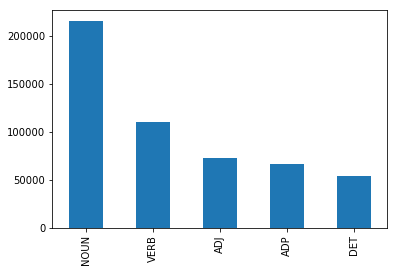

In [6]:
#Top 5 POS still including stop words
Series(pos_dt).sort_values(ascending=False)[0:5].plot(kind='bar')

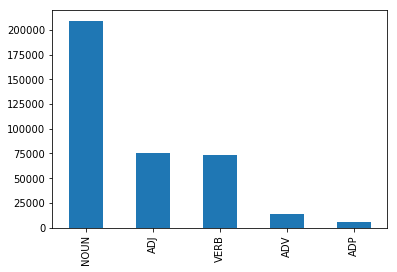

In [7]:
#Top 5 POS after removing stop words
Series(pos_nostop_dt).sort_values(ascending=False)[0:5].plot(kind='bar')

Nouns make up over 200k words of the roughly 400k in the 2500 job descriptions. 

The number of verbs decreased by about 40k after removing stop words. Adposition words (ADP) decreased by over 60k when removing stop words because this category contains words such as "with" and "to". Determiners (DET) decreased from around 60k to barely 200 words because this category contains words such as "a" and "the".

# Part A2

Does this data support Zipf’s law? Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [8]:
#Concatenate all descriptions into one string and split into words
a = df_train['FullDescription'].str.cat(sep = ' ')
s = re.findall('\w+', a)
s = Series(s)

#Get word counts
df_words = DataFrame(s.value_counts())
df_words = df_words.reset_index()
df_words.columns = ['Word','Counts']

In [9]:
#Rank words by count, take log of rank and log of count
df_words['Rank'] = df_words['Counts'].rank(ascending=False)
constant = df_words.iloc[-1]['Counts']*df_words.iloc[-1]['Rank']
df_words['LogCount'] = log(df_words['Counts']/constant)
df_words['LogRank'] = log(df_words['Rank'])

#Run and plot linear regression on the log-log relationship
Y, X = dmatrices('LogRank~LogCount', data=df_words, return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.001e+06
Date:                Thu, 13 Sep 2018   Prob (F-statistic):               0.00
Time:                        12:53:56   Log-Likelihood:                 10874.
No. Observations:               18213   AIC:                        -2.174e+04
Df Residuals:                   18211   BIC:                        -2.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5593      0.005    665.757      0.0

After linear regression, the log(count/min count) has a coefficient of -0.6 with respect to log(rank) so our dataset only loosely follows Zipf's law. A large number of words with low frequencies "flatten" the curve because the change from word to the next does not exactly follow the inverse-rank stated by Zipf's law.

In [10]:
#Same regression but using only the top 100 words
Y, X = dmatrices('LogRank~LogCount', data=df_words[0:100], return_type='dataframe')
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                LogRank   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9309.
Date:                Thu, 13 Sep 2018   Prob (F-statistic):           6.01e-99
Time:                        12:53:56   Log-Likelihood:                 94.287
No. Observations:                 100   AIC:                            -184.6
Df Residuals:                      98   BIC:                            -179.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3869      0.025     55.050      0.0

Looking at only the 100 most frequent words results in a rank-count relationship that follows Zipf's law much closer with a coefficient of almost exactly -1

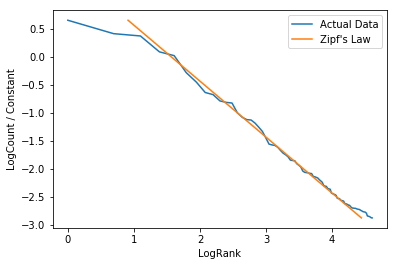

In [12]:
plot(df_words.iloc[0:100]['LogRank'],df_words.iloc[0:100]['LogCount'], linestyle='-', label='Actual Data')
xlabel('LogRank')
ylabel('LogCount / Constant')
plot(log(constant)-df_words.iloc[0:100]['LogCount']-8,df_words.iloc[0:100]['LogCount'], linestyle='-', label="Zipf's Law")
legend(loc='best')

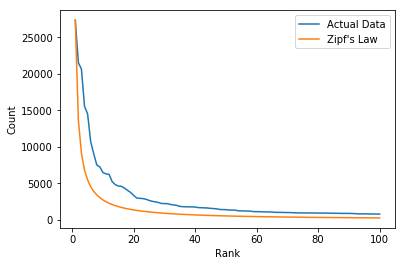

In [13]:
plot(df_words.iloc[0:100]['Rank'],df_words.iloc[0:100]['Counts'], linestyle='-', label='Actual Data')
xlabel('Rank')
ylabel('Count')

df_words['Zipf'] = df_words.iloc[0]['Counts']/df_words['Rank']

plot(df_words.iloc[0:100]['Rank'],df_words.iloc[0:100]['Zipf'], linestyle='-', label="Zipf's Law")
legend(loc='best')

The graph above plots the rank and frequency of the top 100 words in our job descriptions in comparison. The actual word frequencies are higher in the top 100 than Zipf's law would predict, but it follows the general rule that a few words (top 10) have very high frequencies and the counts drop dramatically after the top 20. In the log-log graph, the line for Zipf's law was shifted because of the high intercept value attained from the regression of all 100k+ words.

# Part A3

If we remove stopwords and lemmatize the data, what are the 10 most common words? What are their frequencies?

In [14]:
s = re.findall('\w+', a)
s = [w for w in s if not w in stop_words]

lemmatizer = WordNetLemmatizer()
s = Series(s).map(lemmatizer.lemmatize)

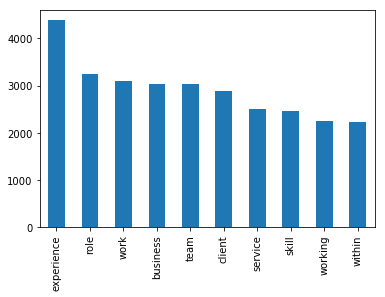

In [15]:
s.value_counts()[0:10].plot(kind='bar')

Experience is the most common word by far, showing up more than 4,000 times in 2,500 job descriptions

# Part B1

Ignore the job descriptions, and train a model to predict high/low salary from all the numeric columns, e.g., part time/full time, contract vs. others, type of job (a lot of dummy variables), location (instead of using a huge number of dummy variables, you can use a list of cities in England with highest cost of living, and create a 0/1 variable which is 1 if the job is in one of those cities, else 0). Use the Naïve Bayes classifier. What is the accuracy of your model?    

In [16]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [17]:
df_train = df_raw.dropna().sample(2500)
cutoff = df_train['SalaryNormalized'].quantile(0.75)

df_train['HighSalary'] = 0
df_train['HighSalary'][df_train['SalaryNormalized']>cutoff] = 1

df_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
154317,71011736,Personal Injury,"Personal Injury, South Manchester. This specia...",Lancashire,Lancashire,full_time,permanent,Sacco Mann,Legal Jobs,"From 28,000 to 30,000 per year + benefits",29000,TotallyLegal,0
19094,67098427,Accountant Financial Services Firm Ipswich,A global financial services firm is looking fo...,Suffolk,Suffolk,full_time,contract,Hewitson Walker,Accounting & Finance Jobs,From 25 to 30 per hour,52800,GAAPweb,1
50312,68631190,Supplier Quality Assurance Engineer Mechanical,Job Title: Supplier Quality Assurance Engineer...,Somerset - Bath,Bath,full_time,permanent,CVbrowser,IT Jobs,30000 - 32000,31000,cvbrowser.com,0
47635,68576328,IP Network Engineer Juniper JNCIA JNCIS &x,IP Network Engineer Juniper JNCIA JNCIS JN...,Berkshire - Reading,Reading,full_time,permanent,UKStaffsearch,Engineering Jobs,45000 - 55000,50000,ukstaffsearch.com,1
19270,67099695,Senior Financial Accountant,Sharp Consultancy is currently recruiting excl...,South Yorkshire,South Yorkshire,full_time,permanent,Sharp Consultancy,Accounting & Finance Jobs,"From 40,000 to 45,000 per year",42500,GAAPweb,0


In [18]:
df_nbtrain = pd.get_dummies(df_train[['ContractType','ContractTime','Category']])

#Cities where avg rent is >= 20% of avg income
high_cities = ['London', 'Central London','The City','Brighton','Edinburgh','Bristol','Southampton','Portsmouth','Exeter'\
                 ,'Cardiff', 'Manchester', 'Birmingham', 'Leeds', 'Aberdeen', 'Glasgow', 'Newcastle', 'Sheffield', 'Liverpool', 'Hull']

a = df_train['LocationNormalized']
b = []

#Create dummy variable for expensive cities
for i in range(len(a)):
    if a.iloc[i] in high_cities: 
        b.append(1)
    else: b.append(0)


df_nbtrain['ExpensiveCity'] = b
df_nbtrain['HighSalary'] = df_train['HighSalary']

#Drop extra dummies
df_nbtrain = df_nbtrain.drop(['ContractType_part_time','ContractTime_contract','Category_Travel Jobs'], axis=1)
df_nbtrain.head()


,ContractType_full_time,ContractTime_permanent,Category_Accounting & Finance Jobs,Category_Admin Jobs,Category_Charity & Voluntary Jobs,Category_Consultancy Jobs,Category_Creative & Design Jobs,Category_Customer Services Jobs,Category_Domestic help & Cleaning Jobs,"Category_Energy, Oil & Gas Jobs",...,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,ExpensiveCity,HighSalary
154317,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19094,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50312,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47635,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19270,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn import metrics

In [20]:
dummy_column_names = list(df_nbtrain.columns.values)[:-1]

formula = 'HighSalary ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))

nbtrain, nbtest = train_test_split(df_nbtrain, test_size=0.3)
    
#Training Sets
Ytrain, xtrain = dmatrices(formula, nbtrain, return_type='dataframe')
ytrain = Ytrain['HighSalary'].values

#Testing Set
Ytest, xtest = dmatrices(formula, nbtest, return_type='dataframe')
ytest = Ytest['HighSalary'].values

model = naive_bayes.MultinomialNB()
model.fit(xtrain, ytrain)

prediction_train = model.predict(xtrain)
print ("Training Accuracy")
print (metrics.accuracy_score(ytrain, prediction_train))

print (" ")
print ("Test Accuracy")
prediction_test = model.predict(xtest)
print (metrics.accuracy_score(ytest, prediction_test))

#Baseline accuracy = if we guessed 'No' for all of them
print (" ")
print ("Baseline Accuracy")
print (1-ytest.mean())

#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
print(' ')
print (metrics.confusion_matrix(ytest, prediction_test))

Training Accuracy
0.753142857143
 
Test Accuracy
0.749333333333
 
Baseline Accuracy
0.749333333333
 
[[562   0]
 [188   0]]


A Binomial Naive Bayes model using every variable except the job description essentially predicts a "Low Salary" for every job and underperforms even the baseline accuracy.

# Part B2 

Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report
import csv
import os

In [22]:
df_text = df_train[['FullDescription','HighSalary']]
df_text['FullDescription'] = df_text['FullDescription'].dropna().str.lower().str.replace('\d+', '')\
.map(lambda x:re.findall('\w+',x)).map(lambda x:' '.join([i for i in x if i not in stop_words \
                                                          and i not in string.punctuation]))

In [23]:
#Split Train and Test sets
#Split descriptions from salary range
X_train, X_test, y_train, y_test = train_test_split(df_text['FullDescription'],
                                                    df_text['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [25]:
#Like the document term matrix, but filled with 1's and 0's instead of TFIDF scores
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

#Fit model on train data
clf = BernoulliNB().fit(X_train_counts, y_train)

#Predict using X_test data
prediction = clf.predict(X_test_counts)

In [26]:
#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_test, prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_test.mean())

Prediction Accuracy
0.801333333333
  
Baseline Accuracy
0.7653333333333333


In [27]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_test, prediction)

array([[533,  41],
       [108,  68]])

Accuracy is high on the Low salary jobs, but below 50% on the high salary jobs.

### Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.  

In [33]:
commonimp = abs(clf.feature_log_prob_[1]-clf.feature_log_prob_[0])

topcommon = Series(commonimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
topcommon[0:10]

comprising      3.152373
schools         3.004606
scenarios       2.864691
teach           2.858895
ks              2.688269
negotiations    2.682369
strategist      2.682369
migration       2.682369
terrific        2.682369
definitions     2.682369
dtype: float64

The words above are the most indicative in our model for predicting salary, either high or low.

In [34]:
highimp = clf.feature_log_prob_[1]-clf.feature_log_prob_[0]

tophigh = Series(highimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
tophigh[0:10]

comprising      3.152373
scenarios       2.864691
definitions     2.682369
footprint       2.682369
negotiations    2.682369
terrific        2.682369
migration       2.682369
strategist      2.682369
fp              2.682369
definition      2.539268
dtype: float64

The words above are the top 10 most indicative of high salary jobs in this model. They seem to describe specific high-level positions that involve things such as negotiations and strategic decisions.

In [35]:
lowimp = clf.feature_log_prob_[1]-clf.feature_log_prob_[0]

toplow = Series(highimp,index=count_vect.get_feature_names()).sort_values(ascending=False)
toplow[-10:]

teachers      -2.282804
technicians   -2.392805
pupils        -2.423576
gcse          -2.453429
technician    -2.482417
graduates     -2.482417
maths         -2.482417
ks            -2.688269
teach         -2.858895
schools       -3.004606
dtype: float64

The words above are the top 10 most indicative of low salary jobs in this model. They seem to center around school and teaching positions, with the exception of technicians which are commonly also low-level jobs.

# Part B3

Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the accuracy of the model. 

In [36]:
df_hybrid = df_text.join(df_nbtrain.drop('HighSalary',axis=1))

X_htrain, X_htest, y_htrain, y_htest = train_test_split(df_hybrid.drop('HighSalary',axis=1),
                                                    df_hybrid['HighSalary'],
                                                    test_size=0.3, random_state=1)

In [37]:
X_htrain_words = count_vect.fit_transform(X_htrain['FullDescription'])
X_htrain_counts = DataFrame(X_htrain_words.todense()).join(X_htrain.drop('FullDescription',axis=1).reset_index())

In [38]:
X_htest_words = count_vect.transform(X_htest['FullDescription'])
X_htest_counts = DataFrame(X_htest_words.todense()).join(X_htest.drop('FullDescription',axis=1).reset_index())

In [39]:
#Fit model on train data
hybrid_model = BernoulliNB().fit(X_htrain_counts, y_htrain)

#Predict using X_test data
hybrid_prediction = hybrid_model.predict(X_htest_counts)

#Percent correct overall
print ('Prediction Accuracy')
print (metrics.accuracy_score(y_htest, hybrid_prediction))
print('  ')
#Baseline accuracy = if we guessed 'No' for all of them
print ('Baseline Accuracy')
print (1-y_htest.mean())

Prediction Accuracy
0.802666666667
  
Baseline Accuracy
0.7653333333333333


In [40]:
#Row 1 is all the ones low salary
#Column 1 is all the ones predicted low salary
metrics.confusion_matrix(y_htest, hybrid_prediction)

array([[533,  41],
       [107,  69]])

The hybrid model is on par with the text-only model with an accuracy of 80.2% vs 80.1%

Even though accuracy increased for "High Salary" jobs, it decreased when predicting the "Low Salary" jobs, which make up 75% of the data. This is not surprising because we saw earlier that the dummy variables such as job category have little to no predictive power.